# Digital Image Processing: DATA 56600-002 
## Multi-label Image Classification with CNN
### Seth Howells

Developing a convolutional neural network for multilabel image classification requires the below imports. The image dataset contained in this notebook is from the tf.keras high-level API, and thus will be downloaded through tf.keras and not locally uploaded from a file. 

Image Dataset: https://keras.io/api/datasets/fashion_mnist/

Altogether, the dataset contains 70,000 images divided into 10 classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot. 

The analysis will be broken into the following parts:

    Import and Load Data
    Explore Data
    Preprocess Data
    Build Model
    Compile Model
    Train Model
    Evaluate & Predict
    Conclusion

## Import and Load Data

In [1]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.callbacks import TensorBoard
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Explore the data

Shape of training data shows: 60k images represented as 28x28 pixels.

Likewise, 60k labels represented as an integer between 0 and 9.

In [3]:
print(f'Number of training images: {train_images.shape[0]} with size of {train_images.shape[1]}x{train_images.shape[2]}')
print(f'Number of testing images: {test_images.shape[0]} with size of {test_images.shape[1]}x{test_images.shape[2]}')

Number of training images: 60000 with size of 28x28
Number of testing images: 10000 with size of 28x28


Class names were not stored in the dataset and thus were obtained from Tensorflow dataset description. The distribution of images per class is an important factor to consider. When the distribution overrepresents a class, the overall model will suffer. On the other hand, when the distribution underrespresents a class, then ...

Here, we see that the 60k training images are evenly assigned to the 10 classes, resulting in 6k training images per class. Likewise with the 10k testing images, each are evenly distributed. 

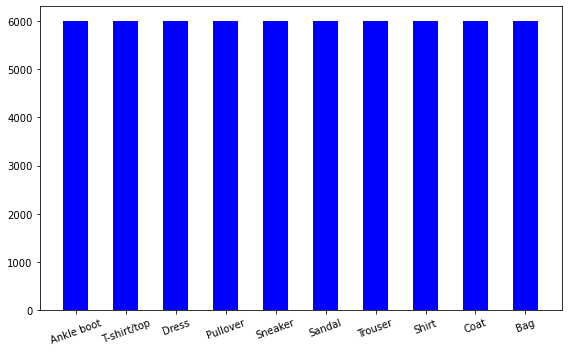

In [4]:
# class names not stored in dataset
# provided here
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Map class names to ith image in training set
newlist = []

for i in train_labels:
    train_labels[i] == class_names[i]
    newlist.append(class_names[i])

label_list = Counter(newlist)

# plot image label distribution
plt.figure(figsize=(8, 5))
plt.bar(range(len(label_list)), list(label_list.values()), width=0.5, color="blue")
plt.xticks(range(len(label_list)), list(label_list), rotation=20)
plt.tight_layout()

## Preprocess the data

First, we want to view some of our images in the dataset. This will confirm that the images have been loaded properly, image labels converted into the correct class string, and provides helpful indicators for preprocessing operations, like converting the image to grayscale. The x and y axis show the dimensions of the image, 28 height by 28 width, which matches the shape of the training and testing set. 

However, notice that the colorbar scale has a range of 0 to 255, which represents the pixel value. In order to feed the values into the neural network model, the values must be scaled down to the range of 0-1. Once the pixel values are transformed, we will plot 25 of the first images to reconfirm the labels as well as view the images with the transformation. 

Category Class: Ankle boot
Integer Class: 9


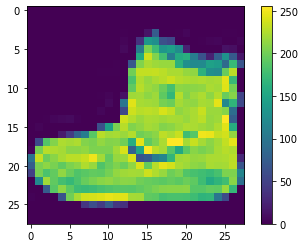

In [5]:
# View first image in dataset
print(f'Category Class: {newlist[0]}\nInteger Class: {train_labels[0]}')

plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [6]:
train_labels[0]

9

In [7]:
train_images = train_images / 255.0
test_images = test_images / 255.0

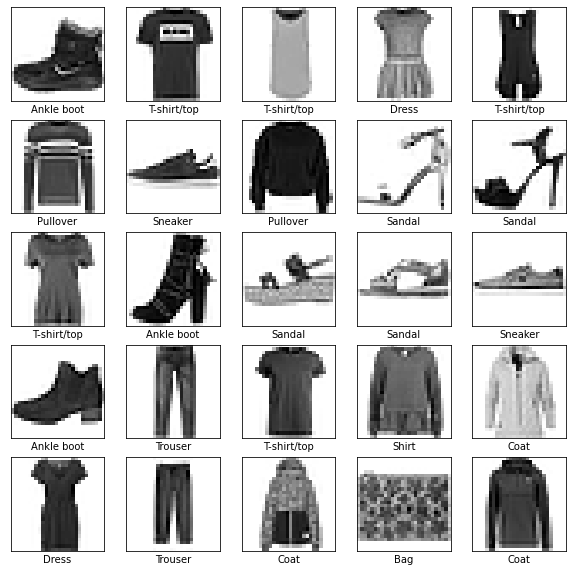

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build the Model

The basic building block of a neural network is the **layer**. Layers extract representations from the data fed into them. 

Most of deep learning consists of chaining together simple layers. Most layers, such as **tf.keras.layers.Dense**, have parameters that are learned during training.

    1st layer: Flatten - unstack rows of images and lines them up (28x28 images converted into 784 pixels)
    2nd layer: Dense - 128 neurons/nodes 
    3rd layer: Dense - return logits w/ length classes (10)
    **Each node contains a score that indicates the current image belongs to one of the 10 classes

The ReLU (rectified linear) activation function plays an integral role in compiling the model. The neural network, composed of layers of nodes, learns to map the input to outputs. Nodes multiply the input by the weight of the node. This value is referred to as the summed activation of the node and is transformed during the activation period. 

It is important to note that ReLU differs from Sigmoid or Hyperbolic Tangent activation functions. ReLU looks for linear functions and if non-linear outputs nothing. This will make not-so-complex datasets faster to train since it bypasses if no linear function is found. Contradistinctively, Sigmoid and Tanh are examples of nonlinear activation functions which can learn from more complex structures. 

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

## Compile the Model

Once the model is built for training, the next step involves compiling the model. There are a few key terms that are important for understanding the learning metrics. The below definitions are borrowed from Tensorflow documentation: https://www.tensorflow.org/tutorials/keras/classification

**Loss function** —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
    
**Optimizer** —This is how the model is updated based on the data it sees and its loss function.

**Metrics** —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the Model

Once the neural network model is compiled, the next step is to start the training:

1. Feed the training data to the model. The training data is in the **train_images** and **train_labels** arrays.
2. Through each iteration the model learns to associate images and labels.
3. Ask the model to make predictions on the test set, which is the **test_images** array.
4. Verify that the predictions match the labels from the **test_labels** array.

To start training, call the model.fit method and define the number of epochs for the training. Epoch refers to the number of times in which all images are processed individually across the network. In this case, we will use 10 epochs with the idea that large enough epochs will create a stronger learning pattern in the latter end of the ith epoch.

In [11]:
h = model.fit(train_images, 
              train_labels, 
              epochs=10, 
              validation_split = 0.2)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
   1/1500 [..............................] - ETA: 3:43 - loss: 2.3733 - accuracy: 0.1250

2022-01-30 12:37:10.763743: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-30 12:37:10.763883: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


1391/1500 [==========================>...] - ETA: 0s - loss: 0.6810 - accuracy: 0.7663WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x297f928b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1500/1500 [==============================] - 1s 591us/step - loss: 0.6695 - accuracy: 0.7700 - val_loss: 0.4184 - val_accuracy: 0.8482

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## Evaluate Accuracy

Next, compare how the model performs on the test dataset:

Notice that the Test Accuracy 88.0% was less than the training accuracy of 91.1% (as per last epoch). The difference between the training and testing data accuracy scores represents **overfitting**.

An **overfitted model** "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. 

Strategies to overcome the problem of overfitting: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting

In [12]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.3414 - accuracy: 0.8806

Test accuracy: 0.8805999755859375


***Plot training and testing metrics:***

Plotting the training and testing metrics can help identify where the model increase or decreases in **accuracy and loss.** As a rule of thumb, we would like to see a positive slope in accuracy and a negative slope in loss.

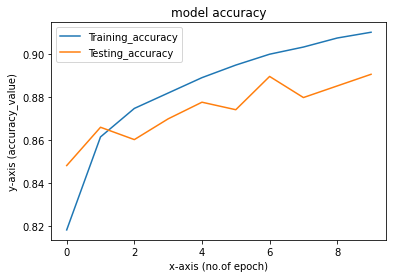

In [21]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Testing_accuracy')
plt.title('model accuracy')
plt.xlabel('x-axis (no.of epoch)')
plt.ylabel('y-axis (accuracy_value)')
plt.legend()
plt.show()

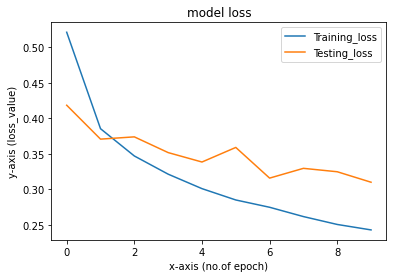

In [22]:
accs = h.history['loss']
val_accs = h.history['val_loss']

plt.plot(range(len(accs)),accs, label = 'Training_loss')
plt.plot(range(len(accs)),val_accs, label = 'Testing_loss')
plt.title('model loss')
plt.xlabel('x-axis (no.of epoch)')
plt.ylabel('y-axis (loss_value)')
plt.legend()
plt.show()

## Make predictions

Now that the model is trained and the accuracy of the model has been evaluated, we can start making predictions on new images, i.e. testing set. Predictions can be made by applying a Softmax layer which convert logits to probabilities. 

In [15]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)
predictions[0]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


array([5.4804997e-07, 8.8145401e-07, 2.7400291e-09, 1.2823419e-07,
       1.4367819e-08, 1.1577191e-03, 1.7390312e-07, 8.9623285e-03,
       5.6844210e-06, 9.8987246e-01], dtype=float32)

The above predictions array contains 10 numbers that represent the "confidence" that the image corresponds to each of the 10 different classes. *prediction* in the code above selects the class with the highest confidence as it's prediction. Therefore, the logits will be converted into a probability - which is much easier to read. 

In [16]:
# shows the top class prediction of 1st image
np.argmax(predictions[0])

9

In [17]:
# verifying if predicted is the same as actual
# result: it is correct
test_labels[0]

9

## Graph predictions

The first 15 test images were used to graph the predictions. Because the model scores nearly 90%, we can expect most of the images to be correctly classified into one of the ten types of clothing articles. Within the first 15 images, we can see one example of a misclassified **Sneaker** as a **Sandal** in red.

In [18]:
# Helper functions
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

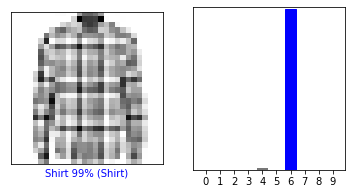

In [19]:
# View ith test image to see prediction breakdown
i = 7
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

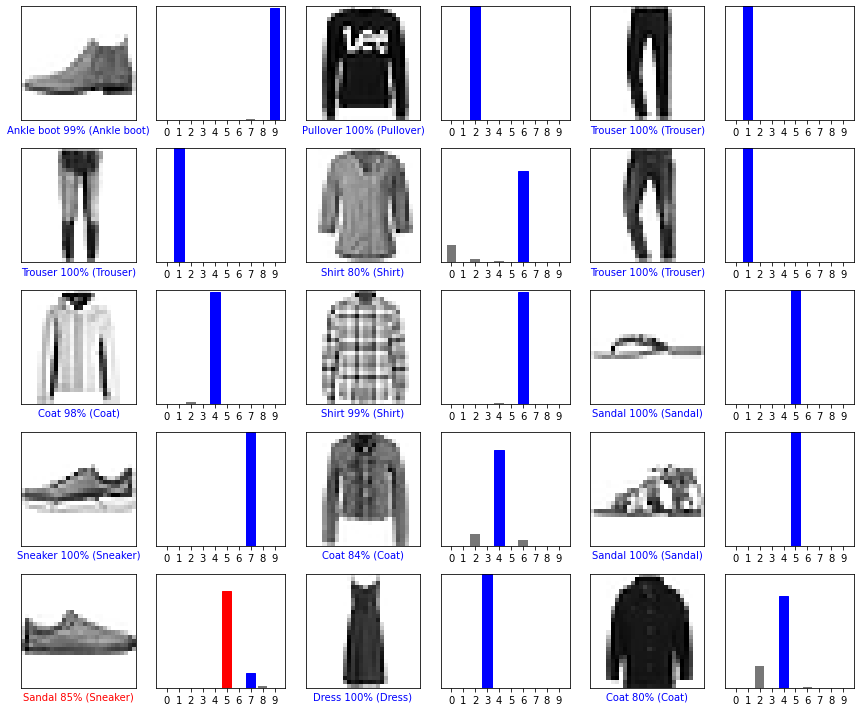

In [26]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3

num_images = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)

plt.tight_layout()
plt.show()

## CONCLUSION



Convolutional neural networks have the ability to learn unique, layered patterns of images and predict a new image’s classification based on the learned patterns. To score high accuracy and decrease loss to zero, ample data is required for multilabel image classification. Because the dataset was collected from keras high-level API, ample data was available. 

While building the model, there were several items to consider aside from the amount of data. Some of these considerations were: the number of epochs, the number of layers, type of activation function, and understanding of the training metrics: loss and accuracy.

In situations where the data is not collected via high-level API and does not contain enough images, data augmentation is likely the best solution since each image will have a transformation applied and appended to the end of the class imageset. 

I was overall pleased with the results, however, would like to further tinker with the number of layers and use the Sigmoid activation function in efforts to increase the accuracy. Another consideration is to increase the number of epochs in hopes that after each additional epoch, the accuracy will increase and the loss will decrease. 